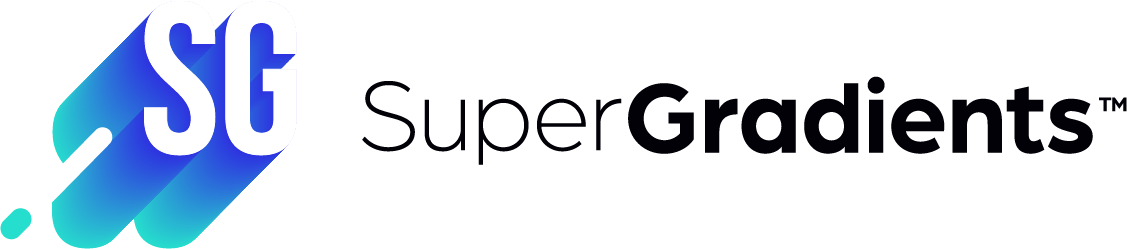

#  Using SuperGradients (**recipes**)

This tutorial will explain what **recipes** are, when and how can recipes help you scallable training and reproducing results, and how to use them.



In [1]:
!pip install -q super-gradients==3.6.0

# What is a **recipe**

To train a model, it is necessary to configure **4** main components:
1. **dataset**: what dataset to use, input size, augmentations, etc.

  ImageNet of size 224x224 with color jitter is one option. CIFAR10 is another. We possibly have our custom dataset and augmentations as-well...

2. **architecture**: what model to train, how many blocks, dropout rate, etc.

  Is it ResNet18? ResNet50? Maybe it's YOLO? or our SuperCustomModel with RepVGG backbone, a dropout probability of 0.2 and bottleneck ratio of 0.5?

3. **training hyperparameters**: number of epochs, initial learning rate, learning rate scheduler, loss function, optimizer, etc.

  Train for 300 epochs using SGD with a learning rate of 0.01, or maybe 400 epochs with Cosine scheduler and ADAM? Should we use EMA or not? What about weight decay? We can plug our custom loss function, metrics, optimizers and others as-well!

4. **checkpoints**: location of pretrained weights, location of current training's checkpoints and artifacts, etc.

All recipes can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/docs/assets/SG_img/Training_Recipes.md)

Recipes support out of the box every model, metric or loss that is implemented in SuperGradients, but you can easily extend this to any custom object that you need by "registering it". Check out [this tutorial](https://github.com/Deci-AI/super-gradients/tree/master/src/super_gradients/common/registry) for more information.

To standardize these components, SG uses the following hierarchy-based format:

```
.
├── src/super_gradients/recipes/
│   ├── arch_params/
│   │   ├── default_arch_params.yaml
│   │   ├── resnet50_arch_params.yaml
│   │   ├── yolo_arch_params.yaml
│   │   └── ...         
│   ├── dataset_params/
│   │   ├── imagenet_dataset_params.yaml
│   │   ├── coco_detection_dataset_params.yaml
│   │   └── ...   
│   ├── training_hyperparams/
│   │   ├── imagenet_resnet50_train_params.yaml
│   │   ├── coco2017_yolox_train_params.yaml
│   │   └── ...  
└── └── checkpoint_params/    
        ├── default_checkpoint_params.yaml
        └── ...
```

These components are aggregated into a single "main" recipe `.yaml` file that inherits the aforementioned dataset, architecture, training and checkpoint params. It is also possible (and recomended for flexibility) to override default settings with custom ones.

Examples of "main" recipes are found at `src/super_gradients/recipes/`. We'll have a glance on `coco2017_yolox.yaml`:

```
defaults:
  - training_hyperparams: coco2017_yolox_train_params
  - dataset_params: coco_detection_dataset_params
  - arch_params: yolox_s_arch_params
  - checkpoint_params: default_checkpoint_params

train_dataloader: coco2017_train
val_dataloader: coco2017_val

model_checkpoints_location: local

load_checkpoint: False
training_hyperparams:
  initial_lr: 0.001

architecture: yolox_s

multi_gpu: DDP
num_gpus: 8

experiment_suffix: res${dataset_params.train_dataset_params.input_dim}
experiment_name: ${architecture}_coco2017_${experiment_suffix}
```

We can understand that this recipe consists of `coco_detection_dataset_params` for dataset, `yolox_s_arch_params` for architecture, `coco2017_yolox_train_params` for training, and `default_checkpoint_params` for checkpoints.

We have overridden the default value of `training_hyperparams.initial_lr` with a value of `0.001`, and we also plan to launch the training using 8 GPUs on DDP mode.




# How to use recipes in SuperGradients

# Getting training hyperparameters based on recipe

Load training hyperparams for ResNet <> ImageNet

In [2]:
from super_gradients.training import training_hyperparams

The console stream is logged into /root/sg_logs/console.log


[2023-10-30 09:36:13] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-10-30 09:36:13] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-10-30 09:36:21] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-10-30 09:36:25] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-10-30 09:36:25] WARNING - export.py - Failed to import pytorch_quantization
[2023-10-30 09:36:25] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-10-30 09:36:25] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-10-30 09:36:25] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-10-30 09:36:25] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-10-30 09:36:25] WARNING - env_sanity_check.py - 

In [3]:
# Two options to load same training hyperparameters
training_params_from_yaml_file = training_hyperparams.get('cifar10_resnet')
training_params_predefined = training_hyperparams.cifar10_resnet_train_params()

# We don't assert values' equality because some are numpy arrays, etc
assert set(training_params_predefined.keys()) == set(training_params_from_yaml_file.keys())

print("TRAINING HYPERPARAMS:")
for k, v in training_params_predefined.items():
    print(f"{k}: {v}")

There are multiple settings in the training hyperparams. All are accessible and modifiable in a key-value way, for example:

In [4]:
training_params_predefined['initial_lr'] = 0.05
print(training_params_predefined['initial_lr'])

You can also overwrite with custom on-the-fly:

In [5]:
training_params_custom = training_hyperparams.cifar10_resnet_train_params(overriding_params={'initial_lr': 0.05})
training_params_custom['initial_lr']

TRAINING HYPERPARAMS:
resume: False
run_id: None
resume_path: None
resume_from_remote_sg_logger: False
ckpt_name: ckpt_latest.pth
lr_mode: StepLRScheduler
lr_schedule_function: None
lr_warmup_epochs: 0
lr_warmup_steps: 0
lr_cooldown_epochs: 0
warmup_initial_lr: None
step_lr_update_freq: None
cosine_final_lr_ratio: 0.01
warmup_mode: LinearEpochLRWarmup
lr_updates: [100 150 200]
pre_prediction_callback: None
optimizer: SGD
optimizer_params: {'weight_decay': 0.0001, 'momentum': 0.9}
load_opt_params: True
zero_weight_decay_on_bias_and_bn: False
loss: CrossEntropyLoss
criterion_params: {}
ema: False
ema_params: {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15}
train_metrics_list: ['Accuracy', 'Top5']
valid_metrics_list: ['Accuracy', 'Top5']
metric_to_watch: Accuracy
greater_metric_to_watch_is_better: True
launch_tensorboard: False
tensorboard_port: None
tb_files_user_prompt: False
save_tensorboard_to_s3: False
precise_bn: False
precise_bn_batch_size: None
sync_bn: False
silent_mode: False


0.05

# Getting a `DataLoader` based on a recipe

Now we'll get a dataloader object from a recipe.



In [6]:
from super_gradients.training.datasets.classification_datasets.cifar import Cifar10
from super_gradients.training import dataloaders

In [7]:
# Load a predefined dataset
train_dataloader = dataloaders.cifar10_train()

# OR use your yaml file. Can also override specific params, such as batch_size
train_dataloader = dataloaders.get_data_loader(
        config_name='cifar10_dataset_params',
        dataset_cls=Cifar10,
        train=True,
        dataloader_params={'batch_size': 42}
)

print("batch size:", train_dataloader.batch_size)

val_dataloader = dataloaders.cifar10_val()

100%|██████████| 170498071/170498071 [00:02<00:00, 82172492.33it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
batch size: 42
Files already downloaded and verified


# Getting a model

In [8]:
from super_gradients.training import models

In [9]:
model = models.get('resnet18', num_classes=10)

# Launch a training, based on model, dataset, training hyperparameters

In [10]:
from super_gradients.training import Trainer

In [11]:
trainer = Trainer("recipe_example", ckpt_root_dir="experiments")

# For the sake of this demonstration we will change the max epochs to 3
training_params_from_yaml_file['max_epochs'] = 3

trainer.train(
    model=model,
    training_params=training_params_from_yaml_file,
    train_loader=train_dataloader,
    valid_loader=val_dataloader
)

[2023-10-30 09:36:36] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2023-10-30 09:36:45] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231030_093645_854856`
[2023-10-30 09:36:45] INFO - sg_trainer.py - Checkpoints directory: experiments/recipe_example/RUN_20231030_093645_854856


The console stream is now moved to experiments/recipe_example/RUN_20231030_093645_854856/console_Oct30_09_36_45.txt


[2023-10-30 09:36:47] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            50000      (len(train_set))
    - Batch size per GPU:           42         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             42         (num_gpus * batch_size)
    - Effective Batch size:         42         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         1191       (len(train_loader))
    - Gradient updates per epoch:   1191       (len(train_loader) / batch_accumulate)

[2023-10-30 09:36:47] INFO - sg_trainer.py - Started training for 3 epochs (0/2)

Validating: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
[2023-10-30 09:38:06] INFO - base_sg_logger.py - Checkpoint saved in experiments/recipe_example/RUN_20231030_093645_854856/ckpt_best.pth
[2023-10-30 09:38:06]

SUMMARY OF EPOCH 0
├── Train
│   ├── CrossEntropyLoss = 1.9838
│   ├── Accuracy = 0.3006
│   └── Top5 = 0.8419
└── Validation
    ├── CrossEntropyLoss = 1.5593
    ├── Accuracy = 0.413
    └── Top5 = 0.9116



Validating epoch 1: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]
[2023-10-30 09:39:17] INFO - base_sg_logger.py - Checkpoint saved in experiments/recipe_example/RUN_20231030_093645_854856/ckpt_best.pth
[2023-10-30 09:39:17] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.47769999504089355


SUMMARY OF EPOCH 1
├── Train
│   ├── CrossEntropyLoss = 1.5782
│   │   ├── Epoch N-1      = 1.9838 (↘ -0.4057)
│   │   └── Best until now = 1.9838 (↘ -0.4057)
│   ├── Accuracy = 0.4151
│   │   ├── Epoch N-1      = 0.3006 (↗ 0.1146)
│   │   └── Best until now = 0.3006 (↗ 0.1146)
│   └── Top5 = 0.9055
│       ├── Epoch N-1      = 0.8419 (↗ 0.0636)
│       └── Best until now = 0.8419 (↗ 0.0636)
└── Validation
    ├── CrossEntropyLoss = 1.4904
    │   ├── Epoch N-1      = 1.5593 (↘ -0.0689)
    │   └── Best until now = 1.5593 (↘ -0.0689)
    ├── Accuracy = 0.4777
    │   ├── Epoch N-1      = 0.413  (↗ 0.0647)
    │   └── Best until now = 0.413  (↗ 0.0647)
    └── Top5 = 0.932
        ├── Epoch N-1      = 0.9116 (↗ 0.0204)
        └── Best until now = 0.9116 (↗ 0.0204)



Validating epoch 2: 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]
[2023-10-30 09:40:27] INFO - base_sg_logger.py - Checkpoint saved in experiments/recipe_example/RUN_20231030_093645_854856/ckpt_best.pth
[2023-10-30 09:40:27] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.5166000127792358


SUMMARY OF EPOCH 2
├── Train
│   ├── CrossEntropyLoss = 1.4117
│   │   ├── Epoch N-1      = 1.5782 (↘ -0.1664)
│   │   └── Best until now = 1.5782 (↘ -0.1664)
│   ├── Accuracy = 0.4885
│   │   ├── Epoch N-1      = 0.4151 (↗ 0.0734)
│   │   └── Best until now = 0.4151 (↗ 0.0734)
│   └── Top5 = 0.9283
│       ├── Epoch N-1      = 0.9055 (↗ 0.0228)
│       └── Best until now = 0.9055 (↗ 0.0228)
└── Validation
    ├── CrossEntropyLoss = 1.5115
    │   ├── Epoch N-1      = 1.4904 (↗ 0.021)
    │   └── Best until now = 1.4904 (↗ 0.021)
    ├── Accuracy = 0.5166
    │   ├── Epoch N-1      = 0.4777 (↗ 0.0389)
    │   └── Best until now = 0.4777 (↗ 0.0389)
    └── Top5 = 0.9226
        ├── Epoch N-1      = 0.932  (↘ -0.0094)
        └── Best until now = 0.932  (↘ -0.0094)



[2023-10-30 09:40:28] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 3:  90%|█████████ | 18/20 [00:06<00:00,  4.26it/s]

# Launch a training based on a **recipe** in a single line!

To load a recipe, you should pass the following CLI argument: `--config-name=my_recipe`, and you also can override settings using `nested.key=value` syntax.

For this example we will set the number of workers for train & validation data loaders to two.

The full override command would look like `dataset_params.train_dataloader_params.num_workers=2 dataset_params.val_dataloader_params.num_workers=2`. To save the time SuperGradients offers a list of shortcut settings to achieve the same result: `num_workers=2`.

You can read more about shortcuts [here](https://docs.deci.ai/super-gradients/latest/documentation/source/Recipes_Training.html#command-line-override-shortcuts):

In [ ]:
!python -m super_gradients.train_from_recipe --config-name=cifar10_resnet num_workers=2

Validating epoch 3: 100%|██████████| 20/20 [00:06<00:00,  3.04it/s]
[2023-10-30 09:40:35] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


The console stream is logged into /root/sg_logs/console.log
[2023-10-30 09:40:38] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-10-30 09:40:38] WARNING - __init__.py - Failed to import pytorch_quantization
2023-10-30 09:40:40.342167: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 09:40:40.342228: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 09:40:40.342273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 09:40:41.986540: W tensorflow/compiler/tf2tensorrt/utils/p